# Imports

In [1]:
import pandas as pd
import os
import sys
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import xml.etree.ElementTree as ET
import numpy as np
import nltk
import string
from nltk.stem import PorterStemmer, SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import pickle
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, naive_bayes, svm
from numpy import loadtxt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU
from tensorflow.keras.layers import Embedding, BatchNormalization
from tensorflow.keras.initializers import Constant
from tensorflow.keras import optimizers
from tensorflow.keras.models import model_from_json
import tensorflow
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Import baza

In [2]:
data = pd.read_csv('pctoken.csv', delimiter = '\t', encoding = 'utf-16', header = None)
data.columns = ['produs', 'rating', 'stem', 'text', 'initial']

data['sentiment'] = 0
for ind in data.index:
    if data['rating'][ind] > 3:
        data['sentiment'][ind] = 1
    elif data['rating'][ind] <= 3:
        data['sentiment'][ind] = 0

<ipython-input-2-188140d0ec44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'][ind] = 1
<ipython-input-2-188140d0ec44>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'][ind] = 0


# Naive Bayes

In [12]:
vectorizer = CountVectorizer(lowercase = True)
y = data.sentiment
x = vectorizer.fit_transform(data.stem)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
clf = naive_bayes.MultinomialNB()
clf.fit(X_train, y_train)
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.7192375877151246

In [4]:
sample = np.array(['un produs excelent, il folosesc in fiecare zi', 'nu imi place acest produs', 'produsul nu functioneaza cum trebuie'])
vect_sample = vectorizer.transform(sample)
print(clf.predict(vect_sample))

[1 1 1]


# Retea Neurala

In [5]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(data['stem'], data['sentiment'], test_size=0.4)
x_train = x_train.values
x_test = x_test.values

y_train = y_train.values
y_test = y_test.values

print(len(x_train) + len(x_test))

x_all = list(x_train) + list(x_test)
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(x_all)

with open('tokenizer.obj', 'wb') as tokenizer_file:
    pickle.dump(tokenizer_obj, tokenizer_file)

vocab_size = len(tokenizer_obj.word_index) + 1

EMBEDDING_DIM = 100

max_length = max([len(s.split()) for s in x_all])

x_train_tokens = tokenizer_obj.texts_to_sequences(x_train)
x_test_tokens = tokenizer_obj.texts_to_sequences(x_test)
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_length, padding='post')
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_length, padding='post')


5931


In [6]:
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
rnn_model.add(GRU(units=64, dropout=0.1, recurrent_dropout=0.1))
rnn_model.add(BatchNormalization())
rnn_model.add(Dense(1, activation='sigmoid'))

_optimizer = optimizers.RMSprop(lr=0.01)
rnn_model.compile(loss='binary_crossentropy', optimizer=_optimizer, metrics=['accuracy'])
print(rnn_model.summary())

print('Started training the model...')
early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = rnn_model.fit(x_train_pad, y_train, 
                        batch_size=32, 
                        epochs=10, 
                        validation_data=(x_test_pad, y_test), 
                        callbacks=[early_stopping],
                        verbose=2)
print('Done training the model...')


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 529, 100)          1043000   
_________________________________________________________________
gru (GRU)                    (None, 64)                31872     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,075,193
Trainable params: 1,075,065
Non-trainable params: 128
_________________________________________________________________
None
Started training the model...
Epoch 1/10
112/112 - 46s - loss: 0.3584 - accuracy: 0.8763 - val_loss: 0.3245 - val_accuracy: 0.9111
Epoch 2/10
112/112 - 43s - loss: 0.2469 - accuracy: 0.9084 - val_loss: 0.2550 - val_accuracy: 0.9119
Epoch

In [ ]:
def store_model(_model, path='./', file_prefix='model_sentiment_rnn'):
    
    # serialize model to JSON
    model_json = _model.to_json()
    json_file_path = os.path.join(path, "{}.json".format(file_prefix))
    print('Started saving model JSON to {}'.format(json_file_path))
    assert os.path.exists(path)
    with open(json_file_path, "w+") as json_file:
        json_file.write(model_json)
    print("Done saving model JSON to {}".format(json_file_path))
    
    # serialize weights to HDF5
    weights_file_path = os.path.join(path, '{}.h5'.format(file_prefix))
    print("Started saving model weights to {}".format(weights_file_path))
    _model.save_weights(weights_file_path)
    print("Done saving model weights to {}".format(weights_file_path))

store_model(rnn_model)


def load_model(path='./', file_prefix='model_sentiment_rnn'):
    # load json and create model
    print('Started loading model from JSON file')
    with open('{}.json'.format(file_prefix), 'r') as json_file:
        loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)
    print('Done loading model from JSON file')
    
    # load weights into new model
    print("Starting loading model from disk")
    weights_file_path = os.path.join(path, '{}.h5'.format(file_prefix))
    assert os.path.exists(weights_file_path)
    loaded_model.load_weights(weights_file_path)
    print("Done loading model from disk from file: {}".format(weights_file_path))
    return loaded_model

model = load_model()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


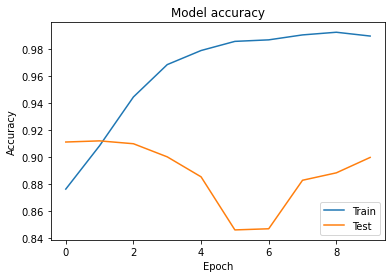

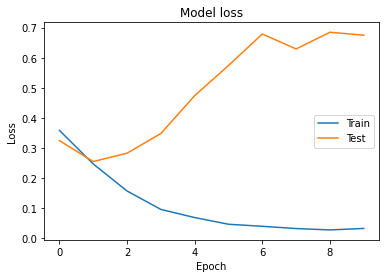

In [7]:
print(history.history.keys())

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='center right')
plt.show()

In [8]:
predictions = rnn_model.predict(x_test_pad)
y_pred = (predictions > 0.5)

confusion_matrix(y_test, y_pred)

array([[  52,  159],
       [  79, 2083]], dtype=int64)

In [9]:
test_samples_tokens = tokenizer_obj.texts_to_sequences(sample)
test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=max_length)

rnn_model.predict(x=test_samples_tokens_pad, batch_size=10, verbose=0)

array([[0.93198633],
       [0.93198633],
       [0.93198633]], dtype=float32)

In [10]:
from predict import sentiment_init, convertTextToIndex
model = sentiment_init('ro')

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Restoring parameters from C:\Users\Mihai\prelucrarea_datelor_text\checkpoints\ro\rotf.tfl


In [11]:
import tensorflow as tf
import pickle
tf.get_logger().setLevel('INFO')
f = open('./dictionaries/'+'ro'+'dictionary.pickle', 'rb')
dictionary = pickle.load(f)
f.close()
data4 = pd.DataFrame()
sample = np.array(['un produs excelent, il folosesc in fiecare zi', 'nu imi place acest produs', 'produsul nu functioneaza cum trebuie'])
for i in sample:
    try:
        text = i
        result = model.predict([convertTextToIndex(dictionary, text)])
        print(' text ='+text)
        print("negative="+str(result[0][0]))
        print("positive="+ str(result[0][1]))
    except Exception as e:
        print(e)


 text =un produs excelent, il folosesc in fiecare zi
negative=0.0047043585
positive=0.9952956
 text =nu imi place acest produs
negative=0.7451168
positive=0.25488326
 text =produsul nu functioneaza cum trebuie
negative=0.27072763
positive=0.7292723
